# [**Régression logistique multiclasse parcimonieuse sur 20newgroups**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_1_linear_model/plot_sparse_logistic_regression_20newsgroups.ipynb)<br/>([_Multiclass sparse logistic regression on 20newgroups_](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_20newsgroups.html))

Comparaison de la régression logistique multinomiale $\ell_1$ et de la régression logistique $\ell_1$ un contre tous (OVR) pour classer les documents de l'ensemble de données newsgroups20. La régression logistique multinomiale donne des résultats plus précis et elle est plus rapide à entraîner sur l'ensemble de données à plus grande échelle.

Ici, nous utilisons la parcimonie $\ell_1$ qui supprime les poids des caractéristiques non informatives pour les mettre à zéro. C'est utile si l'objectif est d'extraire le vocabulaire fortement discriminant de chaque classe. Si l'objectif est d'obtenir la meilleure précision prédictive, il est préférable d'utiliser une pénalité $\ell_2$ qui n'induit pas la parcimonie.

Une approche plus traditionnelle (et peut-être meilleure) pour prédire sur un sous-ensemble parcimonieux de caractéristiques d'entrée serait d'utiliser une sélection univariée de caractéristiques suivie d'un modèle d'une régression logistique traditionnelle ($\ell_2$ pénalisé).

Dataset 20newsgroup, train_samples=4500, n_features=130107, n_classes=20
[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 2
[model=One versus Rest, solver=saga] Number of epochs: 3
Test accuracy for model ovr: 0.5960
% non-zero coefficients for model ovr, per class:
 [0.26593496 0.43348936 0.26362917 0.31973683 0.37815029 0.2928359
 0.27054655 0.62717609 0.19522393 0.30897646 0.34586917 0.28207552
 0.34125758 0.29898468 0.34279478 0.59489497 0.38353048 0.35278655
 0.19829832 0.14603365]
Run time (3 epochs) for model ovr:1.64
[model=Multinomial, solver=saga] Number of epochs: 1
[model=Multinomial, solver=saga] Number of epochs: 2
[model=Multinomial, solver=saga] Number of epochs: 5
Test accuracy for model multinomial: 0.6440
% non-zero coefficients for model multinomial, per class:
 [0.36047253 0.1268187  0.10606655 0.17985197 0.5395559  0.07993421
 0.06686804 0.21443888 0.11528972 0.2075215  0.10914094 0.11144673
 0.1398848

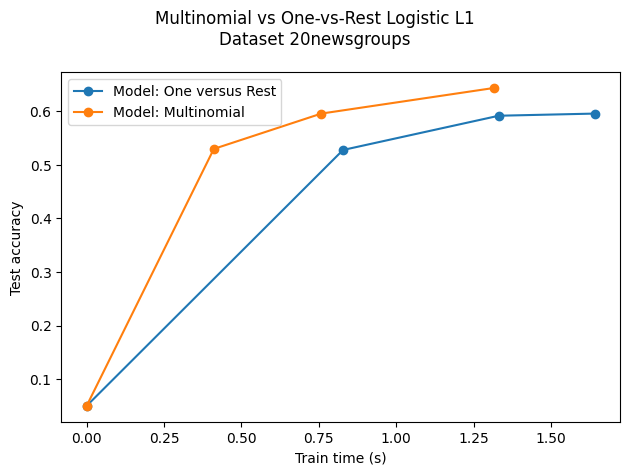

In [1]:
# Author: Arthur Mensch

import timeit
import warnings

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
t0 = timeit.default_timer()

# We use SAGA solver
solver = "saga"

# Turn down for faster run time
n_samples = 5000

X, y = fetch_20newsgroups_vectorized(subset="all", return_X_y=True)
X = X[:n_samples]
y = y[:n_samples]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y, test_size=0.1
)
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

print(
    "Dataset 20newsgroup, train_samples=%i, n_features=%i, n_classes=%i"
    % (train_samples, n_features, n_classes)
)

models = {
    "ovr": {"name": "One versus Rest", "iters": [1, 2, 3]},
    "multinomial": {"name": "Multinomial", "iters": [1, 2, 5]},
}

for model, model_params in models.items():
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params["iters"]:
        print(
            f'[model={model_params["name"]}, solver={solver}] Number of epochs: {this_max_iter}'
        )
        lr = LogisticRegression(
            solver=solver,
            multi_class=model,
            penalty="l1",
            max_iter=this_max_iter,
            random_state=42,
        )
        t1 = timeit.default_timer()
        lr.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]["times"] = times
    models[model]["densities"] = densities
    models[model]["accuracies"] = accuracies
    print("Test accuracy for model %s: %.4f" % (model, accuracies[-1]))
    print(
        "%% non-zero coefficients for model %s, per class:\n %s"
        % (model, densities[-1])
    )
    print(
        "Run time (%i epochs) for model %s:%.2f"
        % (model_params["iters"][-1], model, times[-1])
    )

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]["name"]
    times = models[model]["times"]
    accuracies = models[model]["accuracies"]
    ax.plot(times, accuracies, marker="o", label=f"Model: {name}")
    ax.set_xlabel("Train time (s)")
    ax.set_ylabel("Test accuracy")
ax.legend()
fig.suptitle("Multinomial vs One-vs-Rest Logistic L1\nDataset %s" % "20newsgroups")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print("Example run in %.3f s" % run_time)
plt.show()